# Import the required modules.

In [25]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

In [27]:
pip install np_utils

In [28]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils import to_categorical
# import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

# number_of_samples determine how many samples from the attack and normal dataset should be read and used.

In [29]:
# data=pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/DeepDefense-master/Datasets/dataset_normal.csv')

In [30]:
# data.shape

In [31]:
# from google.colab import drive
# # drive.mount('/content/drive')

# Read data from attack and normal datasets.

In [32]:
data_attack = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/DeepDefense-master/Datasets/dataset_attackfinal.csv', nrows = 150000)

In [33]:
data_normal = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/DeepDefense-master/Datasets/dataset_normalfinal.csv', nrows = 100000)

In [34]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

# Drop unwanted columns

In [35]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
# data=data.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [36]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [37]:
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

# Standardise the data

In [38]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [39]:
X.shape[0]

250000

# the class field, replace value 'attack' with 0 and 'normal' with 1

In [40]:
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1


After feature transformation, we get a 𝑚×𝑛' matrix, where 𝑚 indicates the number of packets and 𝑛' indicates the number of new features after transformation. In order to learn patterns in both long and short term, we use a sliding window to separate continuous packets and reshape the data into a series of time windows with window size 𝑇. The label 𝑦 in each window illustrates the last packet. After reshaping, we have a three-dimensional matrix with shape (𝑚−𝑇 )×𝑇 ×𝑛'. Figure illustrates the workflow of feature extraction, transformation, and reshaping.
![dataset transformation](feature_extraction.png)
In this way, we change the features from conventional packet-based to window-based, by which we can learn network patterns from both previous (𝑇 −1) packets and current packet.

In [41]:
features = len(X[0])
features
samples = X.shape[0]
samples
train_len = 25
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [42]:
X.shape

(250000, 25)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:250000], test_size = 0.2)

In [44]:
X_train.shape

(199980, 25, 25)

In [45]:
from keras.layers import Layer, Dense, LSTM, Bidirectional
from keras.models import Sequential
import keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [46]:

def create_baseline():
    model = Sequential()

    model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
    model.add(AttentionLayer())
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

The architecture used is
![Model](model_brnn.png)

In [47]:
# def create_baseline():
#     model = Sequential()

#     model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
#     model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
#     model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))

#     model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#     return model

In [48]:
model = create_baseline()

In [49]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

In [ ]:
history = model.fit(X_train, Y_train, epochs = 40,validation_split=0.2, verbose = 1)

Epoch 1/40
5000/5000 [==============================] - 176s 32ms/step - loss: 0.3802 - accuracy: 0.8441 - val_loss: 0.2909 - val_accuracy: 0.8881
Epoch 2/40
5000/5000 [==============================] - 136s 27ms/step - loss: 0.2496 - accuracy: 0.9069 - val_loss: 0.2234 - val_accuracy: 0.9201
Epoch 3/40
5000/5000 [==============================] - 137s 27ms/step - loss: 0.1927 - accuracy: 0.9339 - val_loss: 0.1689 - val_accuracy: 0.9495
Epoch 4/40
5000/5000 [==============================] - 135s 27ms/step - loss: 0.1571 - accuracy: 0.9507 - val_loss: 0.1487 - val_accuracy: 0.9556
Epoch 5/40
5000/5000 [==============================] - 137s 27ms/step - loss: 0.1318 - accuracy: 0.9618 - val_loss: 0.1447 - val_accuracy: 0.9552
Epoch 6/40
5000/5000 [==============================] - 146s 29ms/step - loss: 0.1164 - accuracy: 0.9692 - val_loss: 0.2115 - val_accuracy: 0.9070
Epoch 7/40
5000/5000 [==============================] - 148s 30ms/step - loss: 0.1066 - accuracy: 0.9727 - val_loss: 0

Obtained plot of accuracy

![plot of accuracy](BRNN_Model_Accuracy.png)

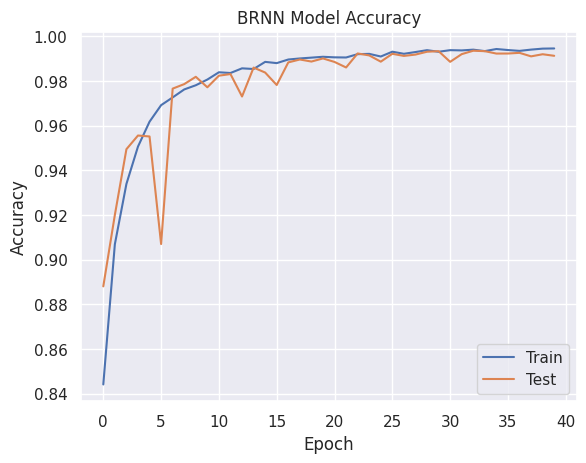

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy2.png')
plt.show()

Plot of loss
![plot of loss](BRNN_Model_Loss.png)

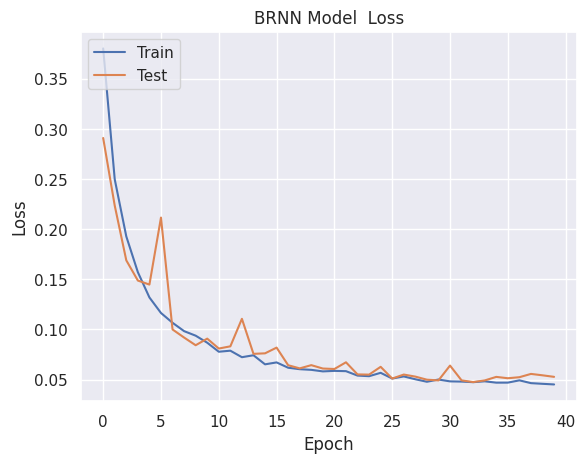

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss2.png')
plt.show()


In [ ]:
predict = model.predict(X_test, verbose=1)

1563/1563 [==============================] - 16s 9ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


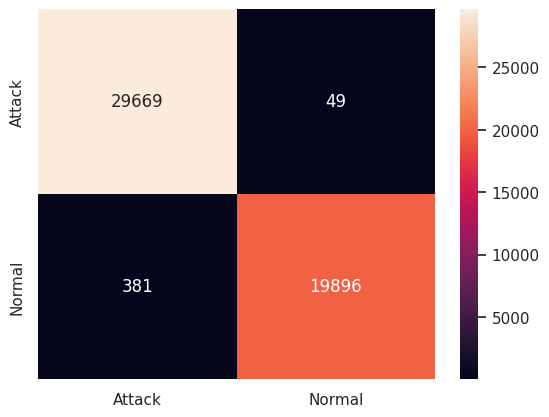

In [ ]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

# Save details

In [ ]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN2.png', dpi=400)

In [ ]:
model.save('/content/drive/MyDrive/MachineLearningCSV/DeepDefense-master/Netprobeattention.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
X_test = X_test.astype('float32')
Y_test = Y_test.astype('float32')

In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.14%
